In [86]:
import os
import glob
import re
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import weatherReturn
import gc  # Added for explicit garbage collection

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset

# … your device setup and print_gpu_memory() …

# ──────────────────────────────────────────────────────────────────────
# A) LOAD PRE-COMPUTED WEEKLY FEATURES
# ──────────────────────────────────────────────────────────────────────
weekly = pd.read_feather('data/output/weekly_seoul.feather')





df_ml  = weekly.copy()

numeric_feats = [
    'vehicle_count','week_of_year',

    'T', 'RH', 'P', 'W', 'S', 'weather_score',
    'is_holiday', 'days_to_hol',
    'rain_flag', 'windy_flag', 'coupon_count',
    # # 인구 통계 변수
    'total_female','total_male', 'pct_child', 'pct_teen', 'pct_adult', 'pct_senior',
    #'totNmprCnt','femlNmprCnt','maleNmprCnt',
    # 조정 지가
    'adj_land_price',
    # cyclical
    'sin_woy','cos_woy','sin_month','cos_month'
]

# 2) Categorical features: only quarter dummies (q_*)
cat_feats = [c for c in df_ml.columns if c.startswith('quarter_')]

# 3) Final feature list
features = numeric_feats + cat_feats

# 4) Slice out X and y
X_raw = df_ml[features].values.astype(np.float32)
#y_raw = np.log(df_ml['rev_per_vehicle'].values.astype(np.float32)).reshape(-1,1)
y_raw =df_ml['rev_per_vehicle'].values.astype(np.float32).reshape(-1,1)


scaler_X = StandardScaler()
X = scaler_X.fit_transform(X_raw)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y_raw).flatten()

# 1) CPU에 FP16 텐서로만 올려 놓기
X_t = torch.from_numpy(X).half()              # CPU float16
y_t = torch.from_numpy(y).half().unsqueeze(1)  # CPU float16

dataset = TensorDataset(X_t, y_t)

In [66]:
y_t

tensor([[-0.7769],
        [-0.1232],
        [-0.0238],
        ...,
        [-1.0557],
        [-1.1455],
        [-1.4551]], dtype=torch.float16)

In [ ]:
from tqdm.auto import tqdm
from torch.amp import autocast as autocast_gpu, GradScaler
import gc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # Enable cuDNN auto-tuner
torch.backends.cudnn.deterministic = False  # Allow non-deterministic algorithms for speed

# Track memory usage
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB / {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print(f"Using device: {device}")
print_gpu_memory()



class ComplexMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        # First block - increased width
        self.block1 = nn.Sequential(
            nn.Linear(in_dim, 512),  # Increased from 256
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
        )
        # Second block - increased width
        self.block2 = nn.Sequential(
            nn.Linear(512, 256),  # Increased from 128
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
        )
        # Third block - increased width
        self.block3 = nn.Sequential(
            nn.Linear(256, 128),  # Increased from 64
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
        )
        # Fourth block - increased width
        self.block4 = nn.Sequential(
            nn.Linear(128, 64),  # Increased from 32
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
        )
        # Final prediction head
        self.head = nn.Linear(64, 1)

        # A simple projection for the residual path
        self.residual_proj = nn.Linear(512, 128)  # Adjusted for new dimensions

    def forward(self, x):
        x = self.block1(x)       # → 512
        x2 = self.block2(x)      # → 256
        # add a skip: project x→128 and add to block3 input
        res = self.residual_proj(x)  
        x3 = self.block3(x2)     # → 128
        x3 = x3 + res            # residual sum
        x4 = self.block4(x3)     # → 64
        return self.head(x4)     # → 1

# IMPROVED TRAINING CONFIGURATION
# Significantly larger batch size for better GPU utilization
BATCH_SIZE = 512  # Increased from 128 to push GPU utilization higher
ACCUMULATION_STEPS = 4  # Reduced as we're using larger batches directly
NUM_WORKERS = 8  # Reduced from 4 to prevent CPU bottleneck
PREFETCH_FACTOR = 6  # Increased prefetch factor

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list, r2_list = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
    # Clear GPU cache before each fold
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()  # Force garbage collection
    
    train_idx, val_idx = train_test_split(train_idx, test_size=0.1, random_state=42)
    
    # IMPROVED DATALOADERS
    loaders = {
    'train': DataLoader(
        Subset(dataset, train_idx),
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,    # multiprocessing OK
        pin_memory=True,           # CPU 텐서이니 pin_memory=True
        persistent_workers=True,
        prefetch_factor=PREFETCH_FACTOR,
    ),
        'val': DataLoader(
            Subset(dataset, val_idx),
            batch_size=BATCH_SIZE*2,  # Larger batch size for validation
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=PREFETCH_FACTOR,
        ),
        'test': DataLoader(
            Subset(dataset, test_idx),
            batch_size=BATCH_SIZE*2,  # Larger batch size for testing
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=PREFETCH_FACTOR,
        ),
    }
    
    # IMPROVED MODEL INITIALIZATION
    model = ComplexMLP(X.shape[1]).to(device)
    
    # MODIFIED: Skip torch.compile for older GPUs (like GTX 1080)
    if device.type == "cuda":
        props = torch.cuda.get_device_properties(device)
        print(f"CUDA Capability: {props.major}.{props.minor}")
        if props.major >= 7:  # Volta or newer
            print(f"Using torch.compile with default backend")
            model = torch.compile(model)  # default Triton+Inductor
        else:
            print(f"CUDA CC {props.major}.{props.minor} <7.0 → skipping compilation")
            # Skip compilation for older GPUs
    else:
        # Skip compilation for CPU as well
        print("Running on CPU without compilation")

    # IMPROVED OPTIMIZER CONFIGURATION
    opt = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)  # Added weight decay
    sched = optim.lr_scheduler.ReduceLROnPlateau(
        opt, 
        factor=0.7,  # More aggressive reduction
        patience=10,  # Reduced patience
        min_lr=1e-6  # Set minimum learning rate
    )
    loss_fn = nn.MSELoss()
    scaler = GradScaler()

    best_val, cnt, patience, best_state = np.inf, 0, 20, None
    
    # Track GPU memory before training
    print_gpu_memory()
    
    # IMPROVED TRAINING LOOP WITH GRADIENT ACCUMULATION
    for epoch in tqdm(range(1000), desc=f'Fold {fold+1} Epochs', leave=False):
        model.train()
        train_losses = []
        
        # Reset gradients at the beginning of each epoch
        opt.zero_grad()
        
        # Training loop with gradient accumulation
        for i, (xb, yb) in enumerate(loaders['train']):
            xb = xb.to(device, non_blocking=True)      # 여기서 GPU 로딩
            yb = yb.to(device, non_blocking=True)
            
            # Mixed precision forward pass
            with autocast_gpu(device_type='cuda', enabled=(device.type == "cuda")):
                pred = model(xb)
                loss = loss_fn(pred, yb)
                # Normalize loss to account for accumulation
                loss = loss / ACCUMULATION_STEPS
                
            # Mixed precision backward pass
            scaler.scale(loss).backward()
            
            # Only step optimizer after accumulation steps
            if (i + 1) % ACCUMULATION_STEPS == 0:
                scaler.step(opt)
                scaler.update()
                opt.zero_grad()
                
            train_losses.append(loss.item() * ACCUMULATION_STEPS)  # Track original loss value
        
        # Handle any remaining gradients
        if (i + 1) % ACCUMULATION_STEPS != 0:
            scaler.step(opt)
            scaler.update()
            opt.zero_grad()
            
        # Calculate average training loss for the epoch
        avg_train_loss = np.mean(train_losses)
            
        # Validation step
        model.eval()
        val_losses = []
        
        with torch.no_grad():
            for xb, yb in loaders['val']:
                xb = xb.to(device, non_blocking=True)      # 여기서 GPU 로딩
                yb = yb.to(device, non_blocking=True)
                
                with autocast_gpu(device_type='cuda', enabled=(device.type == "cuda"),dtype=torch.float16):
                    pred = model(xb)
                    loss = loss_fn(pred, yb)
                    
                val_losses.append(loss.item())
                
        val_loss = np.mean(val_losses)
        
        # Learning rate scheduler step
        sched.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val:
            best_val = val_loss
            best_state = model.state_dict()
            cnt = 0
        else:
            cnt += 1
            #if cnt >= patience:
                #print(f"Early stopping at epoch {epoch}")
                #break
                
        # Print progress every 10 epochs
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}")
            print_gpu_memory()  # Monitor GPU memory
    
    # Load best model for evaluation
    model.load_state_dict(best_state)
    
    # IMPROVED EVALUATION CODE
    preds, trues = [], []
    model.eval()
    
    with torch.no_grad():
        for xb, yb in loaders['test']:
            xb = xb.to(device, dtype=torch.float16, non_blocking=True)
            yb = yb.to(device, dtype=torch.float16, non_blocking=True)
            
            with autocast_gpu(device_type='cuda', enabled=(device.type == "cuda"),dtype=torch.float16):
                pred = model(xb)
                
            # Move predictions back to CPU immediately to free GPU memory
            preds.append(pred.cpu().numpy())
            trues.append(yb.cpu().numpy())
            
    # Stack predictions and ground truth
    preds, trues = np.vstack(preds), np.vstack(trues)

    # right after stacking preds & trues:
    preds_fp32 = preds.astype(np.float32)
    trues_fp32 = trues.astype(np.float32)


    # Transform predictions back to original scale
    y_pred_log = scaler_y.inverse_transform(preds_fp32)
    y_true_log = scaler_y.inverse_transform(trues_fp32)


    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    r2 = r2_score(y_true_log, y_pred_log)

    print(f"Fold {fold+1} — RMSE: {rmse:.2f}, R²: {r2:.3f}")
    rmse_list.append(rmse)
    r2_list.append(r2)
    
    # Free memory
    del model, opt, scaler, loaders
    torch.cuda.empty_cache()
    gc.collect()
    print_gpu_memory()  # Monitor GPU memory

print(f"Avg RMSE: {np.mean(rmse_list):.2f}, Avg R²: {np.mean(r2_list):.3f}")

In [69]:
p = preds.flatten()
t = trues.flatten()

print("preds:   any NaN? ", np.isnan(p).any())
print("preds: any +Inf? ", np.isposinf(p).any())
print("preds: any -Inf? ", np.isneginf(p).any())
print("preds: isfinite? ", np.isfinite(p).all())

print("trues:   any NaN? ", np.isnan(t).any())
print("trues: any +Inf? ", np.isposinf(t).any())
print("trues: any -Inf? ", np.isneginf(t).any())
print("trues: isfinite? ", np.isfinite(t).all())

# If you want counts instead of just boolean:
print("preds NaN count:   ", np.sum(np.isnan(p)))
print("preds +Inf count:  ", np.sum(np.isposinf(p)))
print("preds -Inf count:  ", np.sum(np.isneginf(p)))

preds:   any NaN?  False
preds: any +Inf?  False
preds: any -Inf?  False
preds: isfinite?  True
trues:   any NaN?  False
trues: any +Inf?  False
trues: any -Inf?  False
trues: isfinite?  True
preds NaN count:    0
preds +Inf count:   0
preds -Inf count:   0


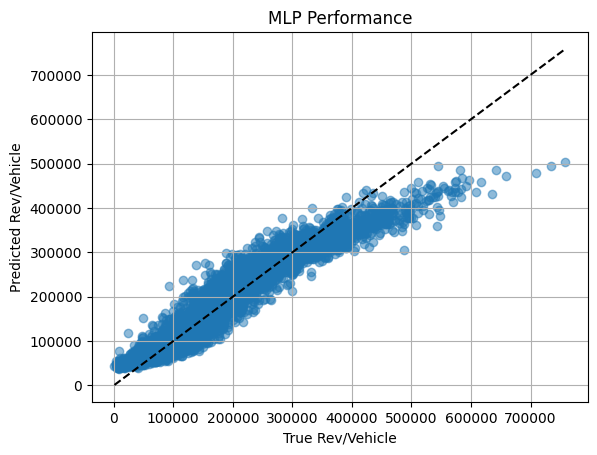

In [98]:
import matplotlib.pyplot as plt

# 9) PLOT RESULTS (last fold)
plt.scatter(trues,preds,alpha=0.5)
mn,mx =trues.min(),trues.max()
plt.plot([mn,mx],[mn,mx],'k--')
plt.xlabel('True Rev/Vehicle'); plt.ylabel('Predicted Rev/Vehicle')
plt.title('MLP Performance')
plt.grid(True)
plt.show()

In [ ]:
import os
import glob
import re
import numpy as np
import pandas as pd
import gc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from torch.cuda.amp import autocast, GradScaler

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from tqdm.auto import tqdm

# 0) DEVICE SETUP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Track GPU memory usage
def print_gpu_memory():
    if torch.cuda.is_available():
        alloc = torch.cuda.memory_allocated() / 1e9
        total = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"GPU Memory: {alloc:.2f} / {total:.2f} GB")

print_gpu_memory()

# 1) LOAD WEEKLY FEATURES
df = pd.read_feather('data/output/weekly_seoul.feather')

# 2) FEATURE SELECTION
numeric_feats = [
    'vehicle_count',
    'T','RH','P','W','S','weather_score',
    'is_holiday','days_to_hol','rain_flag','windy_flag','coupon_count',
    'pct_child','pct_teen','pct_adult','pct_senior',
    'total_pop','total_male','total_female',
    'adj_land_price',
    'sin_woy','cos_woy','sin_month','cos_month'
]
cat_feats = [c for c in df.columns if c.startswith('q_')]
features = numeric_feats + cat_feats

# 3) PREPARE X, y
X_raw = df[features].fillna(0).values.astype(np.float32)
y_raw = np.log1p(df['rev_per_vehicle'].values).reshape(-1,1).astype(np.float32)

# 4) SCALE
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X_raw)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y_raw).flatten()

# 5) BUILD TENSOR DATASET
tensor_X = torch.from_numpy(X)
tensor_y = torch.from_numpy(y).unsqueeze(1)
dataset = TensorDataset(tensor_X, tensor_y)

# 6) MODEL DEFINITION
class ComplexMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512), nn.BatchNorm1d(512), nn.LeakyReLU(), nn.Dropout(0.3),
            nn.Linear(512, 256), nn.BatchNorm1d(256), nn.LeakyReLU(), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.LeakyReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64),  nn.BatchNorm1d(64),  nn.LeakyReLU(), nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

# 7) TRAINING LOOP CONFIG
BATCH_SIZE = 1024
NUM_WORKERS = min(16, os.cpu_count())
PREFETCH = 4
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scaler = GradScaler()

rmse_list, r2_list = [], []
for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
    # cleanup
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    # split train/val
    train_idx, val_idx = train_test_split(train_idx, test_size=0.1, random_state=42)

    loaders = {
        'train': DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True,
                             num_workers=NUM_WORKERS, pin_memory=True,
                             persistent_workers=True, prefetch_factor=PREFETCH),
        'val':   DataLoader(Subset(dataset, val_idx),   batch_size=BATCH_SIZE*2, shuffle=False,
                             num_workers=NUM_WORKERS, pin_memory=True,
                             persistent_workers=True, prefetch_factor=PREFETCH),
        'test':  DataLoader(Subset(dataset, test_idx),  batch_size=BATCH_SIZE*2, shuffle=False,
                             num_workers=NUM_WORKERS, pin_memory=True,
                             persistent_workers=True, prefetch_factor=PREFETCH)
    }

    # init model, optimizer, scheduler, loss
    model = ComplexMLP(X.shape[1]).to(device)
    opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    sched = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5, min_lr=1e-6)
    loss_fn = nn.MSELoss()

    best_val = np.inf
    best_state = None
    early_stop = 50
    patience = 0

    # train epochs
    for epoch in range(1000):
        model.train()
        train_losses = []
        for xb, yb in loaders['train']:
            xb, yb = xb.to(device), yb.to(device)
            with autocast(dtype=torch.float16):
                pred = model(xb)
                loss = loss_fn(pred, yb)
            opt.zero_grad()
            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(opt)
            scaler.update()
            train_losses.append(loss.item())
        avg_train = np.mean(train_losses)

        # validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in loaders['val']:
                xb, yb = xb.to(device), yb.to(device)
                with autocast(dtype=torch.float16):
                    val_pred = model(xb)
                    val_losses.append(loss_fn(val_pred, yb).item())
        avg_val = np.mean(val_losses)
        sched.step(avg_val)

        print(f"Fold {fold+1} Epoch {epoch+1:03d} — Train RMSE: {np.sqrt(avg_train):.4f}, Val RMSE: {np.sqrt(avg_val):.4f}")

        # early stopping
        if avg_val < best_val:
            best_val = avg_val
            best_state = model.state_dict()
            patience = 0
        else:
            patience += 1
            if patience >= early_stop:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # load best
    model.load_state_dict(best_state)

    # test
    preds, trues = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in loaders['test']:
            xb, yb = xb.to(device), yb.to(device)
            with autocast(dtype=torch.float16):
                preds.append(model(xb).cpu().numpy())
                trues.append(yb.cpu().numpy())
    preds = np.vstack(preds)
    trues = np.vstack(trues)

    # right after stacking preds & trues:
    preds = preds.astype(np.float32)
    trues = trues.astype(np.float32)

    # inverse transform & de-log
    preds = scaler_y.inverse_transform(preds)
    trues = scaler_y.inverse_transform(trues)
    preds = np.expm1(preds)
    trues = np.expm1(trues)
    preds = np.clip(preds, 0, None)
    trues = np.clip(trues, 0, None)

    # metrics
    rmse = np.sqrt(mean_squared_error(trues, preds))
    r2 = r2_score(trues, preds)
    print(f"Fold {fold+1} Test — RMSE: {rmse:.3f}, R²: {r2:.3f}")
    rmse_list.append(rmse)
    r2_list.append(r2)

# final results
print(f"Average Test RMSE: {np.mean(rmse_list):.3f}, R²: {np.mean(r2_list):.3f}")


Using device: cuda
GPU Memory: 0.10 / 8.59 GB


C:\Users\User\AppData\Local\Temp\ipykernel_6172\292629145.py:83: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001D1FF210B80>
Traceback (most recent call last):
  File "d:\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "d:\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1622, in _shutdown_workers
    self._mark_worker_as_unavailable(worker_id, shutdown=True)
  File "d:\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1558, in _mark_worker_as_unavailable
    assert self._workers_status[worker_id] or (
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
C:\Users\User\AppData\Local\Temp\ipykernel_6172\292629145.py:123: FutureWarning: `torch.cuda.amp.aut

Fold 1 Epoch 001 — Train RMSE: 1.0756, Val RMSE: 0.9883
Fold 1 Epoch 002 — Train RMSE: 1.0431, Val RMSE: 0.9750
Fold 1 Epoch 003 — Train RMSE: 1.0348, Val RMSE: 0.9604
Fold 1 Epoch 004 — Train RMSE: 1.0352, Val RMSE: 0.9410
Fold 1 Epoch 005 — Train RMSE: 1.0306, Val RMSE: 0.9366
Fold 1 Epoch 006 — Train RMSE: 0.9945, Val RMSE: 0.9166
Fold 1 Epoch 007 — Train RMSE: 0.9625, Val RMSE: 0.9014
Fold 1 Epoch 008 — Train RMSE: 0.9814, Val RMSE: 0.8721
Fold 1 Epoch 009 — Train RMSE: 0.9680, Val RMSE: 0.8709
Fold 1 Epoch 010 — Train RMSE: 0.9623, Val RMSE: 0.8449
Fold 1 Epoch 011 — Train RMSE: 0.9558, Val RMSE: 0.8350
Fold 1 Epoch 012 — Train RMSE: 0.9170, Val RMSE: 0.8127
Fold 1 Epoch 013 — Train RMSE: 0.9048, Val RMSE: 0.7925
Fold 1 Epoch 014 — Train RMSE: 0.9161, Val RMSE: 0.7796
Fold 1 Epoch 015 — Train RMSE: 0.8986, Val RMSE: 0.7650
Fold 1 Epoch 016 — Train RMSE: 0.8627, Val RMSE: 0.7373
Fold 1 Epoch 017 — Train RMSE: 0.8754, Val RMSE: 0.7268
Fold 1 Epoch 018 — Train RMSE: 0.8921, Val RMSE:

C:\Users\User\AppData\Local\Temp\ipykernel_6172\292629145.py:169: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):


Fold 1 Test — RMSE: 37514.180, R²: 0.910


KeyboardInterrupt: 

In [108]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

weekly = pd.read_feather('data/output/weekly_seoul.feather')
weekly_df  = weekly.copy()

# 1) Prepare X, y from your weekly DataFrame (no log-transform if you want direct revenue; or predict log and exp‐back)
features = [
    'vehicle_count','week_of_year',

    'T', 'RH', 'P', 'W', 'S', 'weather_score',
    'is_holiday', 'days_to_hol',
    'rain_flag', 'windy_flag', 'coupon_count',
    # # 인구 통계 변수
    'total_female','total_male', 'pct_child', 'pct_teen', 'pct_adult', 'pct_senior',
    #'totNmprCnt','femlNmprCnt','maleNmprCnt',
    # 조정 지가
    'adj_land_price',
    # cyclical
    'sin_woy','cos_woy','sin_month','cos_month'
]
X = weekly_df[features]
y = weekly_df['rev_per_vehicle']

# 2) Train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) Create LightGBM datasets
dtrain = lgb.Dataset(X_train, label=y_train)
dval   = lgb.Dataset(X_val,   label=y_val, reference=dtrain)

# 4) Set up parameters
params = {
    'objective':        'regression',
    'metric':           'rmse',
    'learning_rate':    0.05,
    'num_leaves':       64,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq':     5,
    'seed':             42,
    'verbosity':        -1,
}

bst = lgb.train(
    params,
    dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dval],
    valid_names=['train','val'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=200)
    ]
)

# 6) Predict & evaluate
y_pred = bst.predict(X_val, num_iteration=bst.best_iteration)
# compute mean squared error (default returns MSE)
mse  = mean_squared_error(y_val, y_pred)

# then take its square root for RMSE
rmse = np.sqrt(mse)

print(f"LightGBM RMSE: {rmse:.3f}")

Training until validation scores don't improve for 50 rounds
[200]	train's rmse: 49511.1	val's rmse: 60222.4
[400]	train's rmse: 41464.8	val's rmse: 59785.4
Early stopping, best iteration is:
[390]	train's rmse: 41783.1	val's rmse: 59758.6
LightGBM RMSE: 59758.602


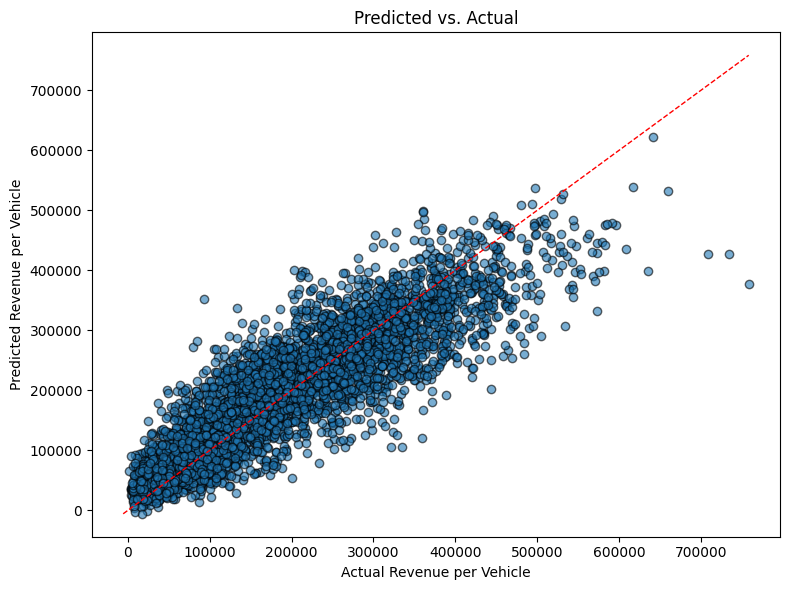

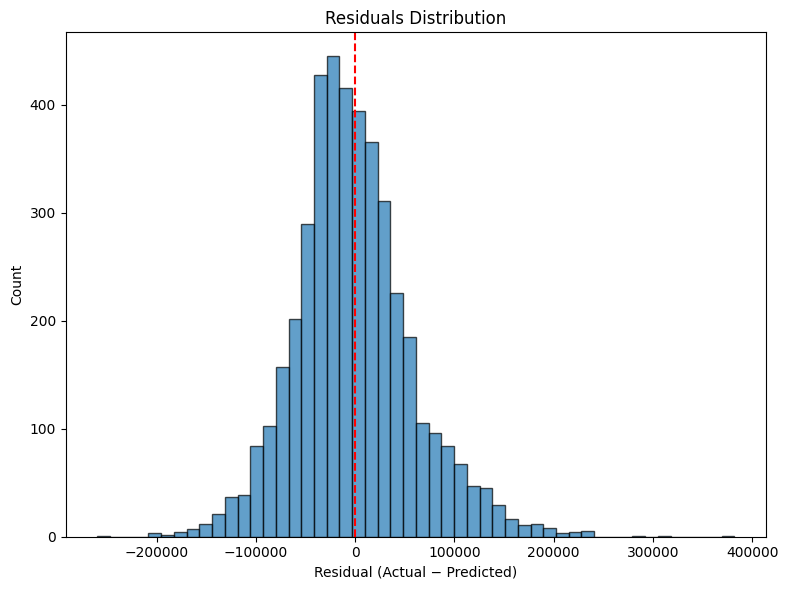

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# ----- Replace these two lines with however you obtain your arrays -----
# For example, from your model run:
#    y_val  = y_true_log_clipped   # or the de-logged values
#    y_pred = y_pred_log_clipped
# Make sure they’re both 1-D numpy arrays of the same length
# ------------------------------------------------------------------------


# Scatter: Predicted vs. Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.6, edgecolor='k')
mn = min(y_val.min(), y_pred.min())
mx = max(y_val.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', lw=1)
plt.xlabel('Actual Revenue per Vehicle')
plt.ylabel('Predicted Revenue per Vehicle')
plt.title('Predicted vs. Actual')
plt.tight_layout()
plt.show()

# Residuals histogram
residuals = y_val - y_pred
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, alpha=0.7, edgecolor='k')
plt.axvline(0, color='r', linestyle='--')
plt.xlabel('Residual (Actual − Predicted)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.tight_layout()
plt.show()


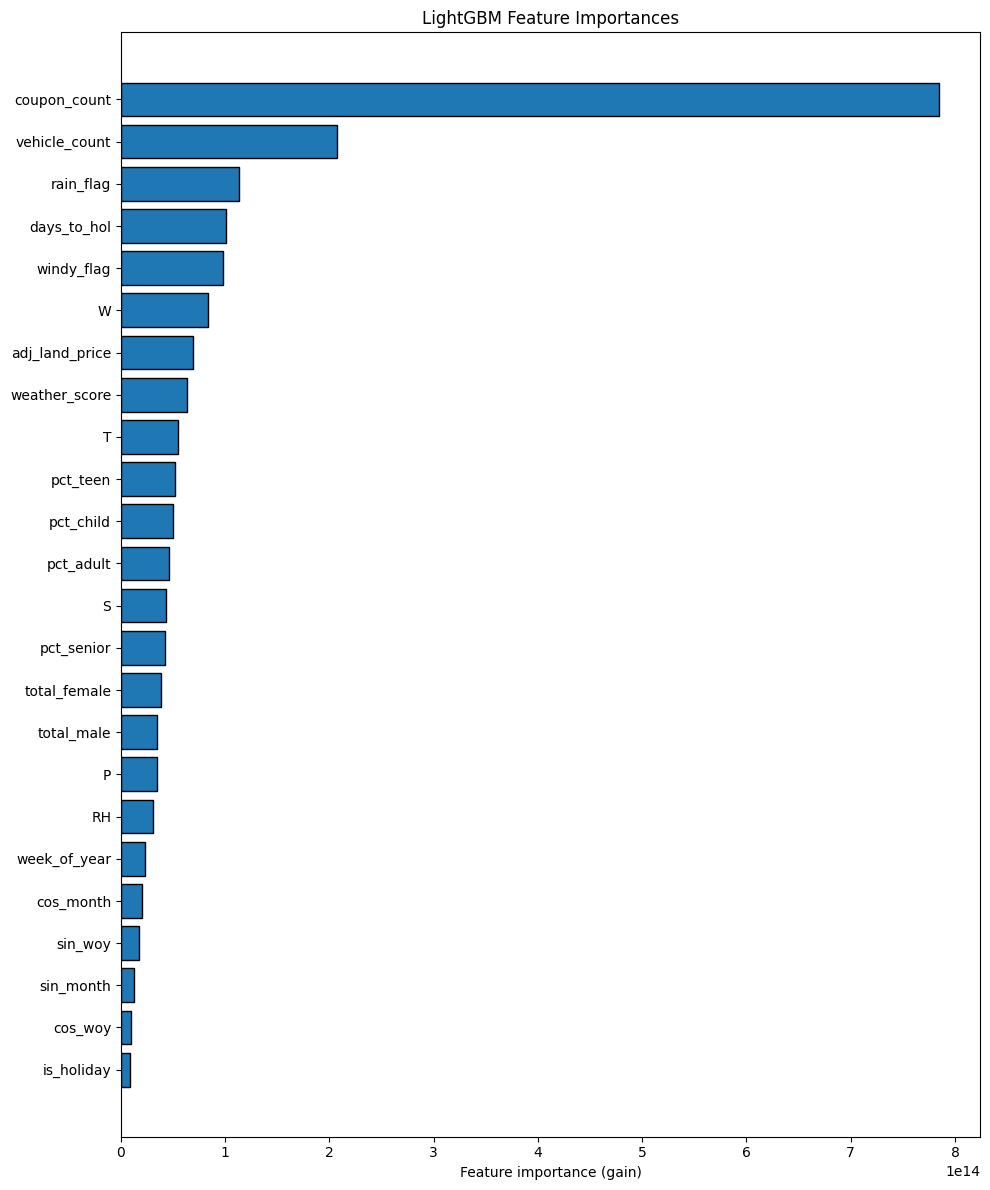

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# 1) extract raw importances and feature names
#    use 'gain' to see which splits gave the most reduction in loss
importances   = bst.feature_importance(importance_type='gain')
feature_names = np.array(features)

# 2) sort descending
idx = np.argsort(importances)[::-1]
sorted_feats = feature_names[idx]
sorted_imp   = importances[idx]

# 3) plot
plt.figure(figsize=(10, 12))
plt.barh(sorted_feats, sorted_imp, edgecolor='k')
plt.gca().invert_yaxis()            # highest importance at the top
plt.xlabel('Feature importance (gain)')
plt.title('LightGBM Feature Importances')
plt.tight_layout()
plt.show()
